# Simon's Algorithm
Generalization of the Simon algorithm that was written for two qbits in the [qiskit textbook](https://qiskit.org/textbook/ch-algorithms/simon.html).

In [1]:
from qiskit import*
from qiskit.visualization import plot_histogram

$s \in \{0,1\}^n$ where n = 1:8 since IBMQ only provides us with 16 qbits.
For simulation purposes though, $n \in N$. Also, if $n>3$, noise mitigation doesn't really work; I guess we're sending "too many" circuits to the real device, the job doesn't get validated.

In [2]:
s = '111'
n = len(s) #register lenght

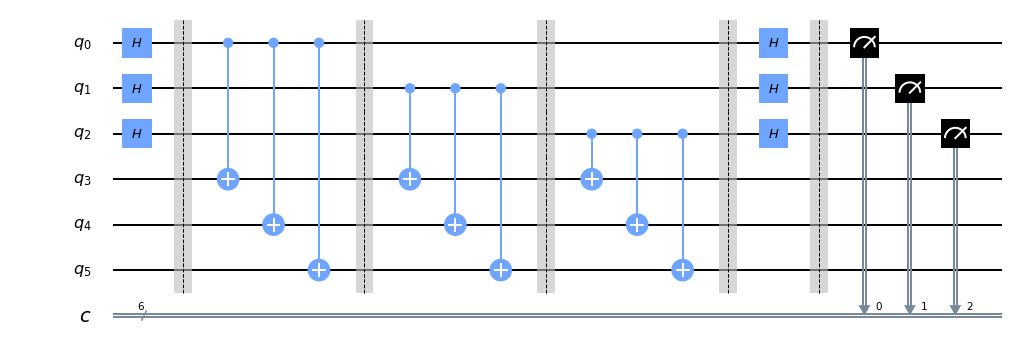

In [3]:
sc = QuantumCircuit(n*2, n*2)

sc.h(range(n))
sc.barrier()

#This is our oracle, the Simon function, that is. 
for i,j in enumerate(reversed(s)):
    if j == '1':
        for q in range(n):
            sc.cx(i, (n) + q)
        sc.barrier()

sc.h(range(n))
sc.barrier()

#Measuring only the first register since in the Simon algorithm, we need not measure the second.
sc.measure(range(n), range(n))

sc.draw('mpl')

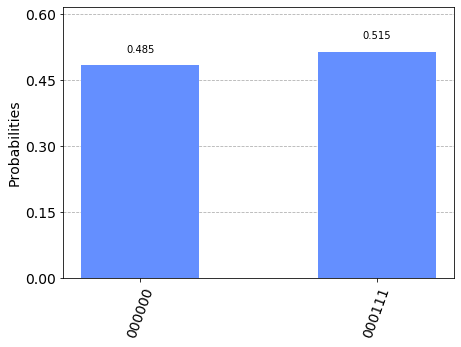

In [4]:
#Let's run a probabilistic simulation to see if our algorithm makes sense.

sim = Aer.get_backend('qasm_simulator')
results = execute(sc, sim).result().get_counts()
plot_histogram(results)


### We're sending it to the real machine now.

In [5]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [6]:
provider = IBMQ.get_provider('ibm-q')
device = provider.get_backend('ibmq_16_melbourne')
job = execute(sc, backend = device, shots = 1024)
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


##### Would it be a surprise to see that it doesn't work as well as the simulation?
We definitely need error correcting, noise reduction, whatever it is.

In [7]:
print(job.result().get_counts())

{'000000': 199, '000110': 81, '000001': 174, '000011': 143, '000010': 158, '000100': 97, '000111': 76, '000101': 96}


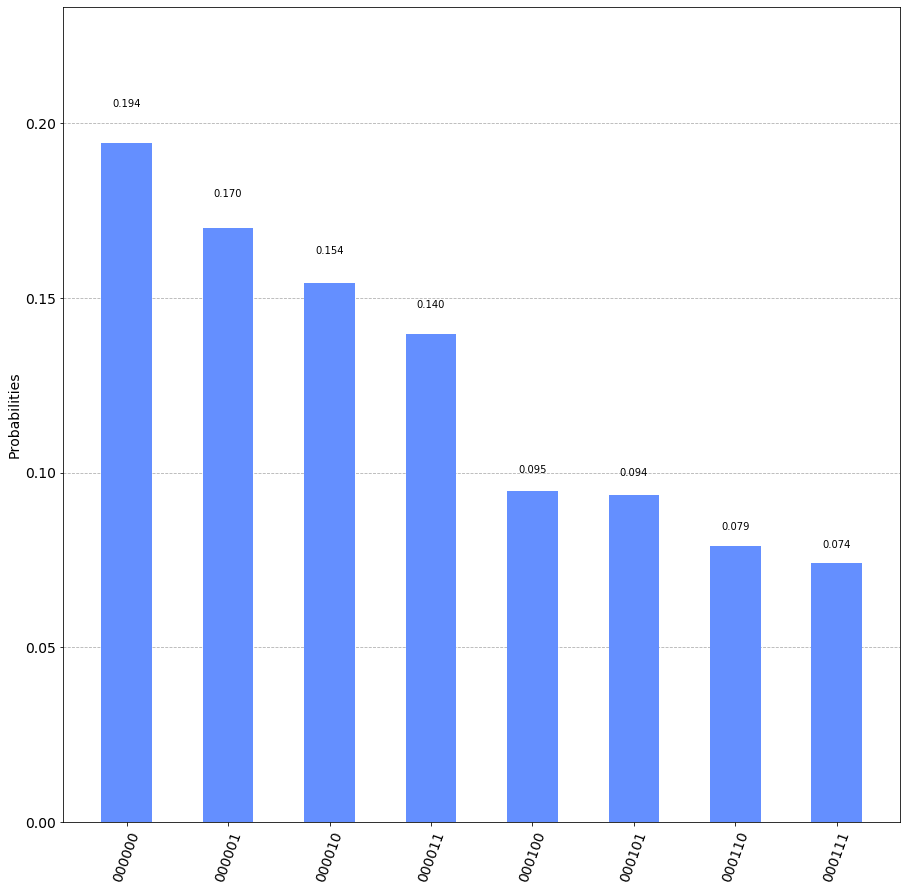

In [8]:
plot_histogram(job.result().get_counts(), figsize= (15,15))

### So, let's mitigate the noise!

In [9]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [10]:
cln_cts, labels = complete_meas_cal(qr = sc.qregs[0])

In [11]:
cal_job = execute(cln_cts,
                 backend = device,
                 shots = 1024,
                 optimization_level = 0)
job_monitor(cal_job)

Job Status: job has successfully run


In [12]:
meas_fitter = CompleteMeasFitter(cal_job.result(), labels)
mitigated_result = meas_fitter.filter.apply(job.result())

In the calibration circuits, all the qbits are measured but we don't need that since in the Simon algorithm, the measurement of the first register is sufficient; the results, in the Simon circuit, will therefore have the form 000xyz whereas in the calibration circuits, pqrstz (where $x,y,z,p,q,r,s,t,z \in \{0,1\}$). We don't want that, no we don't. So let's make the mitigated results and original results match.

In [13]:
mitigated_counts = mitigated_result.get_counts()
mitigated_counts_2 = mitigated_result.get_counts()
print(mitigated_counts)


{'011001': 4.96906118682694e-15, '111010': 9.019491425434067e-15, '000010': 152.37802415241666, '010101': 6.062180922181137e-16, '000111': 93.70391438573496, '110011': 1.9164493126125337e-15, '111000': 4.622617935136353e-15, '000101': 112.2647982374088, '010100': 6.910691094895449e-15, '000100': 95.92086424609982, '111001': 3.645643357509665e-15, '111100': 1.0802963341591254e-14, '011111': 1.2445001084347707e-14, '111101': 5.0570848507056065e-15, '011100': 6.81864233045143e-15, '000000': 168.3028782384561, '010110': 5.565372381693967e-15, '000011': 150.33340554161123, '111110': 1.2015209790647297e-14, '010111': 1.3431001645060336e-14, '000110': 91.7647468317602, '011010': 6.950250921664014e-15, '011011': 3.7712617317192665e-15, '011110': 1.316329857614651e-15, '110100': 2.1654092364695177e-15, '111111': 8.443197313176554e-15, '101111': 4.002061269187118e-17, '000001': 159.33136836651386, '110101': 7.617780646736183e-15, '111011': 6.385340932217598e-15, '011101': 1.067973021216112e-14}


In [14]:
for i in mitigated_counts:
    if i[0] != '0' or i[1] != '0' or i[2] != '0':
        del mitigated_counts_2[i]
print(mitigated_counts_2)

{'000010': 152.37802415241666, '000111': 93.70391438573496, '000101': 112.2647982374088, '000100': 95.92086424609982, '000000': 168.3028782384561, '000011': 150.33340554161123, '000110': 91.7647468317602, '000001': 159.33136836651386}


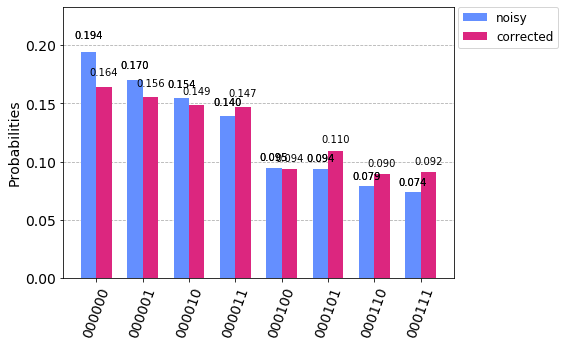

In [15]:
plot_histogram([job.result().get_counts(), mitigated_counts_2], legend = ['noisy', 'corrected'])

That's a bit better but it's still impossible to say what the period s is...